In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import vr2p
import gcsfs
from scipy.io import loadmat
import ast
import matplotlib.pyplot as plt
from vr2p import styles
from scipy import ndimage
from matplotlib import cm,colors,colormaps

# General parameters.

In [2]:
animal = 'A7'
session = 2
pixel_size = [1.3333,2,1] #xyz!

# load (motion) data

In [3]:
# load data
data = vr2p.ExperimentData(f'gs://linear-2ac/Set A-E/Tyche-{animal}')
# get date of sessions for look up
date_str = data.vr[session].info['date_time'][:10]
date_str = date_str.replace('-','_')
# find right folder.
fs = gcsfs.GCSFileSystem(project='sprustonlab-meso')
dir_list = [item['name']for item in fs.listdir(f'gs://linear-2ac/motion/Tyche-{animal}/{date_str}') if item['type']=='directory']
assert len(dir_list)==1, f'Found multiple sessions for {animal} {date_str}'
dir_list = dir_list[0]
# open csv motion file.
csv_file = fs.glob(f'{dir_list}/*.csv')[0]
with fs.open(csv_file, 'rb') as handle:
    motion = pd.read_csv(handle)
motion = motion.rename(columns={' roiName':'roi_name',' frameNumber': 'frame_number',' drPixel':'drift_pix', ' drRef': 'drift_ref'})
motion.drift_pix = motion.drift_pix.apply(lambda x: x[1:].replace(' ',', '))
motion.drift_pix = motion.drift_pix.apply(eval).apply(np.array)
motion.drift_ref = motion.drift_ref.apply(lambda x: x[1:].replace(' ',', '))
motion.drift_ref = motion.drift_ref.apply(eval).apply(np.array)

#motion.drift_pix = motion.drift_pix.astype(float)
motion.roi_name = motion.roi_name.apply(lambda x: x[1:])
# get motion file.
with fs.open(f'gs://{dir_list}/MotionEstimator.me', 'rb') as handle:
    stripe_info = loadmat(handle,simplify_cells=True)
# get offsets in pixels
offset_pix = [] 
for stripe_data in stripe_info['c']:
    scan_field = stripe_data['roiData']['hRoi']['scanfields']
    offset = [ scan_field['pixelToRefTransform'][0,2],scan_field['pixelToRefTransform'][1,2]]
    conversion_factor = [ scan_field['pixelToRefTransform'][0,0],scan_field['pixelToRefTransform'][1,1]]
    offset_pix.append([offset[0]/conversion_factor[0], offset[1]/conversion_factor[1] ])
offset_pix = np.array(offset_pix)
# get stripe order on FOV
stripe_order = offset_pix[:,0].argsort().astype(int)
roi_info = np.array([{'id': roi['roiData']['hRoi']['roiUuid'], 
                     'shape': roi['roiData']['hRoi']['scanfields']['pixelResolutionXY']} for roi in stripe_info['c']])[stripe_order]
# add info 
for roi_number, roi in enumerate(roi_info):
    motion.loc[motion.roi_name==roi['id'][:8],'roi_number']= roi_number
motion.roi_number = motion.roi_number.astype(int)
# get drift in um
motion['x_um'] = motion.drift_pix.apply(lambda x: x[0]*pixel_size[0])
motion['y_um'] = motion.drift_pix.apply(lambda x: x[1]*pixel_size[1])
motion['z_um'] = motion.drift_pix.apply(lambda x: x[2]*pixel_size[2])
# set time minutes.
motion['time_min'] = motion.timestamp/60
print(roi_info)
display(motion.head())

[{'id': '473C81E77DBBBB3E', 'shape': array([462, 682], dtype=uint16)}
 {'id': '8BBF32D60CC37612', 'shape': array([462, 794], dtype=uint16)}
 {'id': 'E62F1DB70712B1D7', 'shape': array([462, 558], dtype=uint16)}]


,timestamp,frame_number,roi_name,z,drift_pix,drift_ref,confidence,userData,roi_number,x_um,y_um,z_um,time_min
0,0.000000,1,8BBF32D6,1300.0,"[0.0, 0.0, -0.909090909090764]","[0.0, 0.0, -0.909090909090764]",[0.0671668499708176 0.0671668499708176 0.0671...,,1,0.000000,0.000000,-0.909091,0.000000
1,0.000000,1,E62F1DB7,1300.0,"[-0.454545454545455, -0.0909090909090909, -1.3...","[-0.00384208972845335, -0.00114822921525715, -...",[0.0539685226976871 0.0539685226976871 0.0539...,,2,-0.606045,-0.181818,-1.363636,0.000000
2,0.000000,1,473C81E7,1300.0,"[0.181818181818182, 0.0909090909090908, -1.363...","[0.00153683589138165, 0.00114822921525715, -1....",[0.0446376465260983 0.0446376465260983 0.0446...,,0,0.242418,0.181818,-1.363636,0.000000
3,0.099867,2,8BBF32D6,1300.0,"[-0.0909090909090909, 0.0909090909090908, -1.3...","[-0.000768417945690825, 0.00114877151494941, -...",[0.064095713198185 0.064095713198185 0.064095...,,1,-0.121209,0.181818,-1.363636,0.001664
4,0.099867,2,E62F1DB7,1300.0,"[-0.818181818181818, -0.0909090909090909, -1.6...","[-0.00691576151121609, -0.00114822921525715, -...",[0.0522341020405293 0.0522341020405293 0.0522...,,2,-1.090882,-0.181818,-1.636364,0.001664


# Plots

[217.  95.   2. 255.]
[117. 112. 179. 255.]
[ 27. 158. 119. 255.]
[217.  95.   2. 255.]
[117. 112. 179. 255.]
[ 27. 158. 119. 255.]
[217.  95.   2. 255.]
[117. 112. 179. 255.]
[ 27. 158. 119. 255.]


Text(0, 0.5, 'Corrected\nOffset ($\\mu$m)')

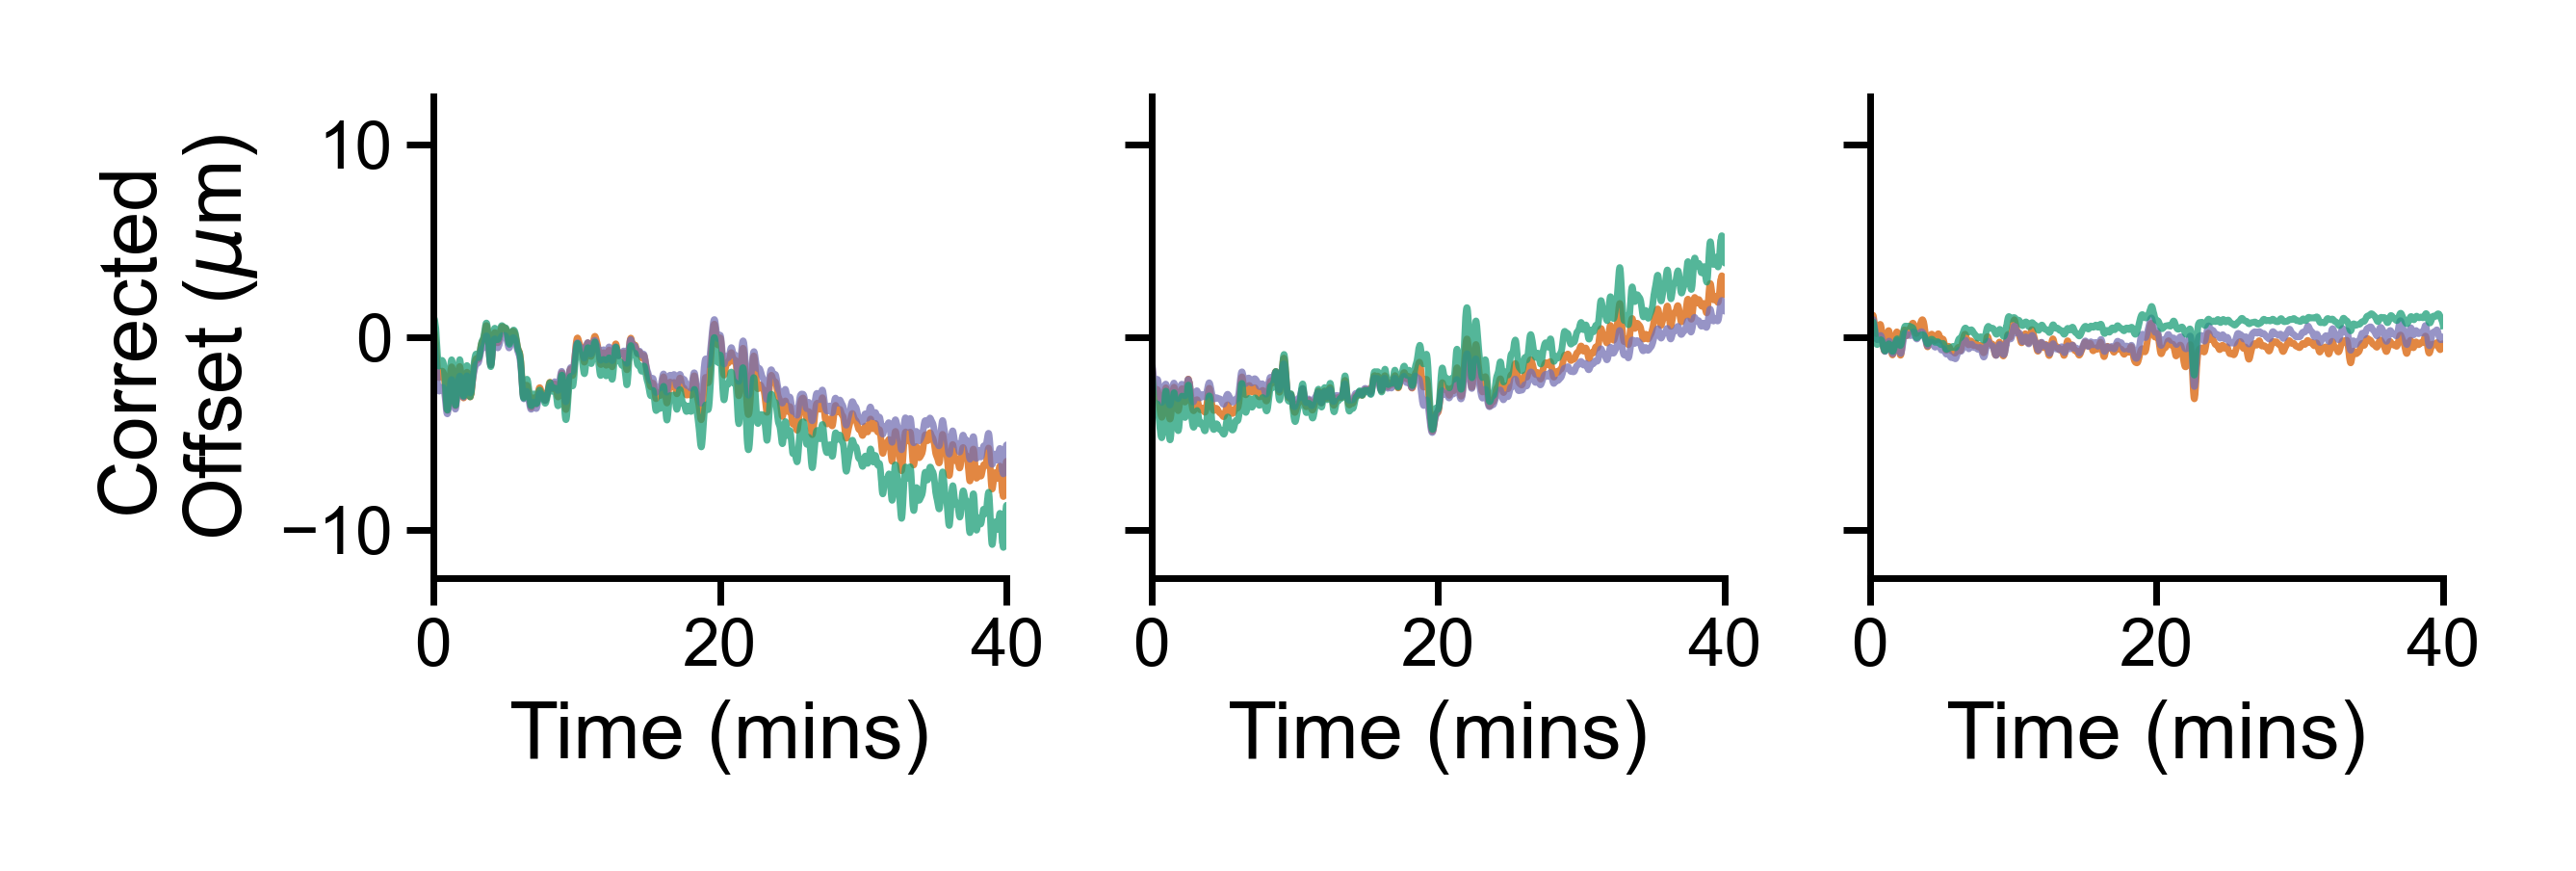

In [4]:
linestyles = ['solid','dotted','dashdot']
colors = colormaps['Dark2']
plt.style.use(styles('publication-tight'))

# plot
axs = plt.figure(figsize=(65/25.4,20/25.4),dpi=1000,layout="constrained").subplot_mosaic(
    [
        ['x','BLANK','y','BLANK','z'],
    ],
    empty_sentinel="BLANK",
    # set the height ratios between the rows
    height_ratios=[1],
    # set the width ratios between the columns
    width_ratios=[1,0.001,1,0.001,1],
)

for dim in ['x','y','z']:
    ax = axs[dim]
    #ax.set_title(f'{dim.upper()}',fontweight='bold')
    for roi_number in motion.roi_number.unique():
        print(np.array(colors(roi_number))*255)
        roi_motion = motion.loc[motion.roi_number==roi_number]
        values = roi_motion[f'{dim}_um']
        # filter.
        values =  ndimage.gaussian_filter1d(values,60)
        ax.plot(roi_motion.time_min, values,color=colors(roi_number),linewidth=0.5,marker='',alpha=0.75)
    ax.set_xlim(0,40)
    ax.set_xlabel('Time (mins)')
# set y limits
axs['x'].set_ylim(-12.5,12.5)
axs['y'].set_ylim(-12.5,12.5)
axs['z'].set_ylim(-12.5,12.5)

axs['y'].set_yticklabels([])
axs['z'].set_yticklabels([])
#axs['z'].set_ylim(-5,5)
axs['x'].set_ylabel('Corrected\nOffset ($\mu$m)')

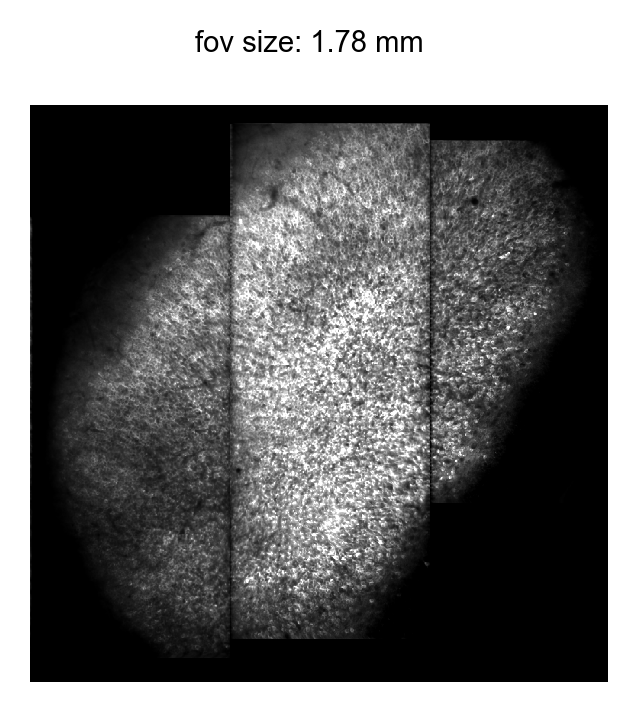

In [5]:
img_type = 'mean_img'
# FOV settings
disp_range = [100,1800]
pix_size = [1.333,2] #xy
fov_size_mm = 1.78
fov_origin_mm = [0,-0.075] # left bottom origin.
show_axis=False

# Grab data.
data = vr2p.ExperimentData(f'gs://linear-2ac/Set A/Tyche-{animal}-SetA.zarr')

#plot
fig = plt.figure(figsize=(2.5,2.5),dpi=300)
ax = fig.add_subplot(1, 1, 1)

ax.set_facecolor("black")
# get images.
img = data.images.original[session][img_type]
fov_mm = [[fov_origin_mm[0],fov_origin_mm[0] + fov_size_mm],
          [fov_origin_mm[1],fov_origin_mm[1] + fov_size_mm]] # fov crop in x -y
ax.imshow(img, origin='lower',extent=[0,(img.shape[1]*pix_size[0])/1000, 0,(img.shape[0]*pix_size[1])/1000], interpolation='none',cmap='gray', vmin=disp_range[0], vmax=disp_range[1]) # correct non uniform aspect ratio.
ax.set_xlim(fov_mm[0])
ax.set_ylim(fov_mm[1])

fig.suptitle(f'fov size: {fov_size_mm} mm')
# format
if not show_axis:
    ax.tick_params(left = False, bottom=False)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

# Appendix confirm xyz order of pixels

The scanimage had some strange internal referernce coordinate system so the values of drift_ref are hard to translate to micrometers.

To avoid this issue I just use the pixel values but I needed to make sure the order is actually XYZ.

These assert checks this and use the fact that the width of all stripes is equal.

In [6]:
#print(stripe_info['c'][1]['roiData']['hRoi']['scanfields']['affine'])
# check first value for size is indeed the width (x) (should be equal across stripes)
assert stripe_info['c'][1]['roiData']['hRoi']['scanfields']['pixelResolutionXY'][0] == stripe_info['c'][0]['roiData']['hRoi']['scanfields']['pixelResolutionXY'][0] ,'widths were not equal'
# check that this also holds for the scaling affine.
assert stripe_info['c'][1]['roiData']['hRoi']['scanfields']['affine'][0,0] == stripe_info['c'][0]['roiData']['hRoi']['scanfields']['affine'][0,0], 'affine scale x was not equal'
## check that first drift value uses the x scaling value
internal_x_scaling = stripe_info['c'][1]['roiData']['hRoi']['scanfields']['affine'][0,0]/stripe_info['c'][1]['roiData']['hRoi']['scanfields']['pixelResolutionXY'][0]
print( round(motion.iloc[2].drift_pix[0]*internal_x_scaling,10) == round( motion.iloc[2].drift_ref[0],10))
print(f'{round(motion.iloc[2].drift_pix[0]*internal_x_scaling,10)} equals {round( motion.iloc[2].drift_ref[0],10)}')

True
0.0015368359 equals 0.0015368359
